In [1]:
!pip install sqlalchemy

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [5]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [6]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [7]:
# напишите запрос
query = '''
SELECT CAST(DATE_TRUNC('month', creation_date) AS date) AS month_date,
       SUM(views_count) AS total_views
FROM stackoverflow.posts
GROUP BY month_date
ORDER BY total_views DESC
'''
z1 = pd.read_sql_query(query, con = engine)
display(z1)
# выполните запрос

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Данные по просмотром отличаются за каждый месяц. Это может быть связано с количеством постов, которые публиковались в различные даты. Чем меньше новых постов, тем меньше просмотров. Человек редко будет дважды смотреть один и тот же пост

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [8]:
# напишите запрос
query = '''
WITH act_users_number AS 
(SELECT p.user_id,
        u.display_name,
        p.creation_date AS pd,
        u.creation_date AS rd,       
        COUNT(pt.type) OVER(PARTITION BY u.display_name) AS number_of_answers
FROM stackoverflow.users AS u 
JOIN stackoverflow.posts AS p ON u.id = p.user_id
JOIN stackoverflow.post_types AS pt ON p.post_type_id = pt.id
WHERE pt.type = 'Answer'
AND DATE_TRUNC('day',p.creation_date) >= DATE_TRUNC('day',u.creation_date)  
AND DATE_TRUNC('day',p.creation_date) <= DATE_TRUNC('day',u.creation_date) + INTERVAL '1 month'
)
 
SELECT 
       display_name,
       COUNT(DISTINCT user_id)
FROM act_users_number
WHERE number_of_answers > 100
GROUP BY display_name
ORDER BY display_name;
'''

# выполните запрос
z2 = pd.read_sql_query(query, con = engine)
display(z2)

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
74,lomaxx,1
75,mattlant,1
76,paxdiablo,1
77,tvanfosson,1


В основном для каждого имени пользователей количество уникальных значений идентификатора пользователя равно 1, но есть и аномалия в виде 8.

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [9]:
# напишите запрос
query = '''
SELECT DATE_TRUNC('month', creation_date)::date AS month,
       COUNT(*)
FROM stackoverflow.posts
WHERE user_id IN(
    SELECT u.id AS users
    FROM stackoverflow.users u 
    JOIN stackoverflow.posts p ON p.user_id = u.id
    WHERE extract(year from p.creation_date) = 2008
        and extract(year from u.creation_date) = 2008
         and extract(month from p.creation_date) = 12
         and extract(month from u.creation_date) = 9
    )
GROUP BY month
ORDER BY month DESC
'''
z3 = pd.read_sql_query(query, con = engine)
display(z3)
# выполните запрос

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Есть 32 поста за август, хотя пользователи зарегистрировались только в сентябре. Они могли появиться из за технической ошибки.

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [10]:
# напишите запрос
query = '''
SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date)
FROM stackoverflow.posts 
ORDER BY user_id,creation_date
'''
z4 = pd.read_sql_query(query, con = engine)
display(z4.head(10))
# выполните запрос

,user_id,creation_date,views_count,sum
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
5,1,2008-08-04 08:04:42,0,616509
6,1,2008-08-10 08:28:52,0,616509
7,1,2008-08-11 19:23:47,0,616509
8,1,2008-08-12 00:30:43,0,616509
9,1,2008-08-12 04:59:35,72431,688940


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [11]:
# напишите запрос
query = '''
WITH first AS 
    (
    SELECT user_id, 
           count(creation_date) as total
    FROM stackoverflow.posts
    WHERE CAST(DATE_TRUNC('month',creation_date) AS date ) = '2008-08-01' 
    GROUP BY 1
    HAVING count (creation_date) > 120 
),
second as 
(
    SELECT count(DISTINCT CAST(DATE_TRUNC('day', creation_date) AS date)) as days , 
           user_id,
           total
    FROM first 
    INNER JOIN stackoverflow.posts using (user_id)
    WHERE CAST(DATE_TRUNC('day', creation_date)as date ) BETWEEN '2008-08-01' AND '2008-08-31'
    GROUP BY 2,3
    ORDER BY 2
)
SELECT user_id,
       (total::numeric/days::numeric) as avg_daily
FROM second
ORDER BY avg_daily
'''
z5 = pd.read_sql_query(query, con = engine)
display(z5)
# выполните запрос

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [12]:
# напишите запрос
query = '''
SELECT ROUND(AVG(fr.cnt))
FROM(SELECT COUNT(DISTINCT EXTRACT(DAY FROM creation_date::date)) AS cnt
FROM stackoverflow.posts
WHERE creation_date:: date BETWEEN '2008-12-01' AND '2008-12-07'
GROUP BY user_id) AS fr

'''
z6 = pd.read_sql_query(query, con = engine)
display(z6)

# выполните запрос

,round
0,2.0


То есть за неделю пользователи взаимодействуют с платформой в среднем два дня. Предположительно, это могут быть выходные дни.

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [13]:
# напишите запрос
query = '''
SELECT user_id,
       creation_date,
       LAG(TO_CHAR(creation_date, 'Month'), 2, NULL) OVER (PARTITION BY user_id ORDER BY creation_date)
FROM stackoverflow.posts
ORDER BY user_id, creation_date;
'''
z7 = pd.read_sql_query(query, con = engine)
display(z7.head(10))
# выполните запрос

,user_id,creation_date,lag
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
5,1,2008-08-04 08:04:42,August
6,1,2008-08-10 08:28:52,August
7,1,2008-08-11 19:23:47,August
8,1,2008-08-12 00:30:43,August
9,1,2008-08-12 04:59:35,August


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [14]:
# напишите запрос
query = '''
         
WITH profile AS
   (SELECT user_id,
    date_trunc('month',creation_date) as cohort_dt,
    COUNT(*) OVER (PARTITION BY DATE_TRUNC('month', MIN(creation_date))::date) AS cohort_users_cnt
    FROM stackoverflow.posts
    GROUP BY 1,2),
sessions AS 
   (SELECT user_id,
    date_trunc('month',creation_date) as session_date
    FROM stackoverflow.posts
    GROUP BY user_id,
         session_date)
SELECT p.cohort_dt,
       session_date,
       COUNT(p.user_id) AS users_cnt,
       cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile p
JOIN sessions s ON p.user_id = s.user_id
where session_date >= cohort_dt
GROUP BY 1,
         2,
         4; 

'''
z8 = pd.read_sql_query(query, con = engine)
display(z8.head(50))

# выполните запрос

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-12-01,2008-12-01,8304,8304,100.00
1,2008-10-01,2008-10-01,9038,9038,100.00
2,2008-07-01,2008-10-01,2,3,66.67
3,2008-08-01,2008-09-01,1572,2153,73.01
4,2008-08-01,2008-11-01,1051,2153,48.82
5,2008-11-01,2008-12-01,4532,8509,53.26
6,2008-08-01,2008-08-01,2153,2153,100.00
7,2008-09-01,2008-11-01,3877,9250,41.91
8,2008-09-01,2008-09-01,9250,9250,100.00
9,2008-08-01,2008-12-01,896,2153,41.62


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

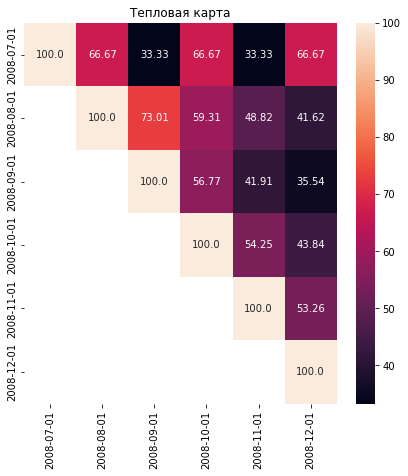

In [15]:
import seaborn as sns
 
retention = z8.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]
 
plt.figure(figsize=(7, 7))  # задаём размер графика
sns.heatmap(retention, # указываем датафрейм с данными
            annot=True, #включаем подписи
            fmt='') #задаём исходный форма
plt.title('Тепловая карта') # задаём название графика
plt.show()

В любые месяцы коэффициент удержания на следующий выше 50%, в августе даже выше 70%. В целом, есть там где падает ниже 40%, но RR держится хорошо.

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [16]:
# напишите запрос
query = '''

SELECT lag.month,
       lag.cnt,
       ROUND(((lag.cnt::numeric/lag.lg-1)*100),2)
FROM(
      SELECT mth.month,mth.cnt,LAG(mth.cnt,1) OVER (ORDER BY mth.month) lg
      FROM(
      SELECT EXTRACT(MONTH FROM creation_date::date) AS month,
             COUNT(id) AS cnt
             FROM stackoverflow.posts
             WHERE creation_date::date BETWEEN '2008-09-01' AND '2008-12-31'
             GROUP BY month
        ) AS mth
) AS lag


'''
z9 = pd.read_sql_query(query, con = engine)
display(z9.head(10))
# выполните запрос

,month,cnt,round
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

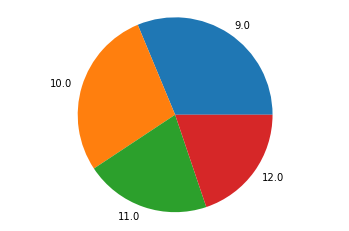

In [17]:
vals=z9['cnt']
labels=z9['month']
fig, ax = plt.subplots();
ax.pie(vals, labels=labels);
ax.axis("equal");

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [18]:
# напишите запрос
query = '''
WITH max_post AS 
(SELECT user_id, count(*) as cnt
FROM stackoverflow.posts
GROUP BY user_id
ORDER BY cnt desc
limit 1)
SELECT extract(week from p.creation_date) as week_creation, max(p.creation_date)
FROM stackoverflow.posts as p
WHERE extract(month from p.creation_date) = 10 and p.user_id in (SELECT user_id FROM max_post)
GROUP BY week_creation

'''
z10 = pd.read_sql_query(query, con = engine)
display(z10.head(10))

# выполните запрос

,week_creation,max
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01
